In [2]:
from point_coordinates_regression import *
from Deformation_gradient import *
from math import acos,sqrt,pi

%matplotlib qt

In [3]:
# extracting information about deformation gradient and barycenter

def extract_barycenter_deformation_gradients(points,nb_of_points):
    
    ref_triangle = np.array([[-0.5,0],[0.5,0],[0,0.5*sqrt(3)]])

    dX=np.array([      
       [ref_triangle[1][0]-ref_triangle[0][0] , ref_triangle[2][0]-ref_triangle[0][0]] ,   
       [ref_triangle[1][1]-ref_triangle[0][1] , ref_triangle[2][1]-ref_triangle[0][1]]
                ])
    
    
    deformation_gradients=[]
    barycenters=[]
    
    polygons=points.reshape(len(points),nb_of_points,2)
    
    for polygon in polygons:
        barycenter=np.array([polygon[:,0].sum()/nb_of_points,polygon[:,1].sum()/nb_of_points])
        barycenter_triangles=[]
        barycenters.append(barycenter)
        for i in range(nb_of_points):
            barycenter_triangles.append(np.array([barycenter,polygon[i],polygon[(i+1)%nb_of_points]]))
        for triangle in barycenter_triangles:
            F=get_deformation_gradient(triangle)
            deformation_gradients.append(F)
    barycenters=np.array(barycenters).reshape(len(points),1,2)
    deformation_gradients=np.array(deformation_gradients).reshape(len(points),1,4*nb_of_points)
    
    return np.dstack([deformation_gradients,barycenters])

def extract_barycenter(points,nb_of_points):
        
    barycenters=[]
    
    polygons=points.reshape(len(points),nb_of_points,2)
    for polygon in polygons:
        barycenter=np.array([polygon[:,0].sum()/nb_of_points,polygon[:,1].sum()/nb_of_points])
        barycenter_triangles=[]
        barycenters.append(barycenter)
        for i in range(nb_of_points):
            barycenter_triangles.append(np.array([barycenter,polygon[i],polygon[(i+1)%nb_of_points]]))
    barycenters=np.array(barycenters).reshape(len(points),1,2)
    
    return np.array(barycenters)




def extract_deformation_gradients(points):
    
    ref_triangle = np.array([[-0.5,0],[0.5,0],[0,0.5*sqrt(3)]])

    dX=np.array([      
       [ref_triangle[1][0]-ref_triangle[0][0] , ref_triangle[2][0]-ref_triangle[0][0]] ,   
       [ref_triangle[1][1]-ref_triangle[0][1] , ref_triangle[2][1]-ref_triangle[0][1]]
                ])
    
    
    deformation_gradients=[]
    barycenters=[]
    
    points=points.reshape(len(points),3,2)
    for triangle in points:
        barycenter=compute_triangle_barycenter(triangle)
        barycenter_triangles=[]
        barycenters.append(barycenter)
        for i in range(3):
            barycenter_triangles.append(np.array([barycenter,triangle[i],triangle[(i+1)%3]]))
        for triangle in barycenter_triangles:
            F=get_deformation_gradient(triangle)
            deformation_gradients.append(F)
    barycenters=np.array(barycenters).reshape(len(points),1,2)
    deformation_gradients=np.array(deformation_gradients).reshape(len(points),1,12)
    
    return np.array(deformation_gradients)



def extract_distances_from_barycenter(polygon_set,nb_of_points):   
    contour_barycenter_distances=[]
    for polygon  in polygon_set:
        distances_from_barycenter=[]
        polygon=np.delete(polygon,2*nb_of_points).reshape(nb_of_points,2)
        polygon_barycenter=np.array([polygon[:,0].sum()/nb_of_points,polygon[:,1].sum()/nb_of_points])
        for polygon_point in polygon:
            distance_from_barycenter=np.linalg.norm(polygon_point-polygon_barycenter)
            distances_from_barycenter.append(distance_from_barycenter)
        contour_barycenter_distances.append(distances_from_barycenter)
    contour_barycenter_distances=np.array(contour_barycenter_distances)
    return contour_barycenter_distances



def acquire_points_from_deformation(deformgrad_barycenters,nb_of_points):
    
    ref_triangle = np.array([[-0.5,0],[0.5,0],[0,0.5*sqrt(3)]])

    dX=np.array([      
       [ref_triangle[1][0]-ref_triangle[0][0] , ref_triangle[2][0]-ref_triangle[0][0]] ,   
       [ref_triangle[1][1]-ref_triangle[0][1] , ref_triangle[2][1]-ref_triangle[0][1]]
                ])
    
    deformgrad_barycenters=deformgrad_barycenters.reshape(1,nb_of_points*4+2)
    for deformation_gradients_with_barycenter in deformgrad_barycenters:
        points=[]
        barycenter=np.array(deformation_gradients_with_barycenter[-2:])
        print("barycenter is ", barycenter)
        deformation_gradients=np.array(deformation_gradients_with_barycenter[0:4*nb_of_points]).reshape(nb_of_points,2,2)
        for deformation_gradient in deformation_gradients:
            X=(np.array([barycenter,barycenter]).T+np.matmul(deformation_gradient,dX)).T
            points.append(X)
    return points





def length(v):
    return sqrt(v[0]**2+v[1]**2)
def dot_product(v,w):
    return v[0]*w[0]+v[1]*w[1]
def determinant(v,w):
    return v[0]*w[1]-v[1]*w[0]
def inner_angle(v,w):
    cosx=dot_product(v,w)/(length(v)*length(w))
    rad=acos(cosx) # in radians
    return rad*180/pi # returns degrees
def angle_counterclockwise(A, B):
    inner=inner_angle(A,B)
    det = determinant(A,B)
    if det<0: 
        return 360-inner
    else: 
        return inner

    
    
def sort_points(point_coordinates,nb_of_points):
    polygon=point_coordinates.reshape(len(point_coordinates),nb_of_points,2)
    barycenters=extract_barycenter(point_coordinates,nb_of_points)
    angles=[]
    polygons=point_coordinates.reshape(len(point_coordinates),nb_of_points,2)
    vectors=polygons-barycenters

    for  barycenter_vectors in vectors:
        for vector in barycenter_vectors:
            angles.append(angle_counterclockwise(np.array([1,0]),vector))
                      
    angles=np.array(angles).reshape(len(vectors),nb_of_points,1)
    point_coordinates_with_angles=np.dstack([polygons,angles])
    point_coordinates_sorted=[]
    for points in point_coordinates_with_angles:
        points_sorted=np.array(sorted(points,key=lambda x: x[2]))
        points_sorted=points_sorted[:,0:2]
        point_coordinates_sorted.append(points_sorted.reshape(1,nb_of_points,2))
    return np.array(point_coordinates_sorted)    
    




In [40]:
polygons_initial=load_dataset('12_polygons.pkl')
point_coordinates_initial=load_dataset('12_point_coordinates_del.pkl')
number_of_insertion_points=load_dataset('12_nb_of_points_del.pkl')

In [41]:
nb_of_points=10
polygons_reshaped,point_coordinates=reshape_data(polygons_initial,point_coordinates_initial,number_of_insertion_points,nb_of_points)

In [42]:
#polygons_reshaped.shape,point_coordinates.shape
#
point_coordinates=sort_points(point_coordinates,nb_of_points)


In [44]:
# Shuffle the data

polygons_reshaped,point_coordinates=unison_shuffled_copies(polygons_reshaped,point_coordinates)
_,lengths,polygon_angles=extract_lengths_angles(polygons_reshaped,12)

In [45]:
# 80/20 training/test data ratio

nb_of_test_data=int(len(polygons_reshaped)*0.2)
nb_of_training_data=int(len(polygons_reshaped)-nb_of_test_data)
nb_of_test_data,nb_of_training_data


barycenter_distances=extract_distances_from_barycenter(polygons_reshaped,12)
polygons_reshaped_with_angles=np.hstack([polygons_reshaped,polygon_angles])
polygons_reshaped_with_angles_and_lengths=np.hstack([polygons_reshaped_with_angles,lengths])
polygons_reshaped_with_angles_and_lengths_bd=np.hstack([polygons_reshaped_with_angles_and_lengths,barycenter_distances])




lengths_and_angles=np.hstack([lengths,polygon_angles])


In [46]:
# Taking the coordinates as input
x_tensor=torch.from_numpy(polygons_reshaped_with_angles_and_lengths_bd[:nb_of_training_data]).type(torch.FloatTensor)
x_tensor_test=torch.from_numpy(polygons_reshaped_with_angles_and_lengths_bd[nb_of_training_data:]).type(torch.FloatTensor)
x_variable,x_variable_test=Variable(x_tensor),Variable(x_tensor_test)


In [47]:
deformation_gradients_with_barycenters=extract_barycenter_deformation_gradients(point_coordinates,nb_of_points)

#deformation_gradients_with_barycenters=deformation_gradients_with_barycenters.reshape(len(deformation_gradients_with_barycenters),1,3,4)[:,0,1]
#deformation_gradients_with_barycenters=deformation_gradients_with_barycenters.reshape(len(deformation_gradients_with_barycenters),1,4)

In [48]:
# The output are the deformation gradients of the triagles that are formed after connecting the barycenter with each edge 
# of the polygon and the barycenter of the polygon. The polygon is formed after connecting each interior point.


y_tensor=torch.from_numpy(deformation_gradients_with_barycenters[:nb_of_training_data]).type(torch.FloatTensor)
y_tensor_test=torch.from_numpy(deformation_gradients_with_barycenters[nb_of_training_data:]).type(torch.FloatTensor)

y_variable,y_variable_test=Variable(y_tensor),Variable(y_tensor_test)


In [49]:
my_net=Net(x_variable.size()[1],y_variable.size()[2],nb_of_hidden_layers=2, nb_of_hidden_nodes=70,batch_normalization=True)
torch.cuda.empty_cache()
print("Training data length:",x_variable_test.size()[1],y_variable.size()[2])


Training data length: 61 42


In [50]:
optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-4,weight_decay=0.7)
loss_func =torch.nn.MSELoss(size_average=False) 


In [51]:

if  torch.cuda.is_available():
    #loss_func.cuda()
        
    x_variable , y_variable=x_variable.cuda(), y_variable.cuda()
    x_variable_test,y_variable_test= Variable(x_tensor_test.cuda(),volatile=True),Variable(y_tensor_test.cuda(),volatile=True)

    print("cuda activated")


cuda activated


In [52]:
batch_size=int(x_variable.size()[0] )
nb_of_epochs=13000
my_net.cuda()
#my_net.cpu()

# Train the network #
my_net.train()
for t in range(nb_of_epochs):
    sum_loss=0
    for b in range(0,x_variable.size(0),batch_size):
        out = my_net(x_variable.narrow(0,b,batch_size))                 # input x and predict based on x
       # loss= loss_func(out, y_variable.narrow(0,b,batch_size))     # must be (1. nn output, 2. target), the target label is NOT one-hotted
        #loss=my_torch_loss_function(out, y_variable.narrow(0,b,batch_size).resize(batch_size,nb_of_points*4+2)).sum().cuda()
        loss=my_torch_loss_function3(out, y_variable.narrow(0,b,batch_size).resize(batch_size,nb_of_points*4+2),x_variable.narrow(0,b,batch_size)[:,24],.4).sum().cuda()

        sum_loss+=loss.data[0]
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients

        optimizer.step()        # apply gradients
    if t%10==0: 
        my_net.eval()
        out_test=my_net(x_variable_test)   
        test_loss=my_torch_loss_function3(out_test, y_variable_test.resize(y_variable_test.size()[0],nb_of_points*4+2),x_variable_test[:,24],.4).sum().cuda()

        #test_loss=loss_func(out_test, y_variable_test)
       # test_loss=my_torch_loss_function(out_test, y_variable_test.resize(len(y_variable_test),nb_of_points*4+2)).sum()

        print("Epoch:",t,"Training Loss:",sum_loss/(x_variable.size(0)),test_loss.data[0]/(x_variable_test.size(0)))
        my_net.train()


Epoch: 0 Training Loss: 35.02343916046759 27.956112498671484
Epoch: 10 Training Loss: 34.19338801806589 34.00778509937294
Epoch: 20 Training Loss: 33.393085812964934 33.32974412796259
Epoch: 30 Training Loss: 32.62397383103082 32.559487591667555
Epoch: 40 Training Loss: 31.884893065887354 31.819776942289298
Epoch: 50 Training Loss: 31.17370151434644 31.108772186204696
Epoch: 60 Training Loss: 30.48915382571732 30.42516141460304
Epoch: 70 Training Loss: 29.829679197662063 29.767111276437454
Epoch: 80 Training Loss: 29.19382970244421 29.133210224253375
Epoch: 90 Training Loss: 28.580609059511158 28.52237551812095
Epoch: 100 Training Loss: 27.989814691817216 27.934271707939207
Epoch: 110 Training Loss: 27.42118922688629 27.368943631097885
Epoch: 120 Training Loss: 26.874745948459086 26.826505872037412
Epoch: 130 Training Loss: 26.3502424282678 26.30555518652354
Epoch: 140 Training Loss: 25.8473731402763 25.80608991391221
Epoch: 150 Training Loss: 25.36563164187035 25.327243198001913
Epoch

Epoch: 1300 Training Loss: 16.66328540116897 16.69031147040068
Epoch: 1310 Training Loss: 16.655624003719446 16.683002975874164
Epoch: 1320 Training Loss: 16.648025704038258 16.67580740514401
Epoch: 1330 Training Loss: 16.64048219978746 16.66871811563397
Epoch: 1340 Training Loss: 16.633008435175345 16.661673663513657
Epoch: 1350 Training Loss: 16.625596107863974 16.65464249654586
Epoch: 1360 Training Loss: 16.618248538788524 16.647671112764375
Epoch: 1370 Training Loss: 16.610954104675876 16.640772797321713
Epoch: 1380 Training Loss: 16.60372442879915 16.633930943777234
Epoch: 1390 Training Loss: 16.59655452975558 16.62714223084281
Epoch: 1400 Training Loss: 16.589432784272052 16.62041828302689
Epoch: 1410 Training Loss: 16.58236417375133 16.613765742905727
Epoch: 1420 Training Loss: 16.57534205632306 16.607149736953982
Epoch: 1430 Training Loss: 16.56839465993624 16.600566943883514
Epoch: 1440 Training Loss: 16.561498738044634 16.593989132745243
Epoch: 1450 Training Loss: 16.55464266

Epoch: 2580 Training Loss: 15.966722569075452 16.0627457753215
Epoch: 2590 Training Loss: 15.962338934643995 16.059128892549687
Epoch: 2600 Training Loss: 15.957946997874602 16.05557511425231
Epoch: 2610 Training Loss: 15.953568344845909 16.052072815920926
Epoch: 2620 Training Loss: 15.949183049946866 16.048543947284514
Epoch: 2630 Training Loss: 15.944786131774707 16.045046630885324
Epoch: 2640 Training Loss: 15.940394195005313 16.041609097672442
Epoch: 2650 Training Loss: 15.936028825717322 16.038257917950897
Epoch: 2660 Training Loss: 15.931676740170031 16.034890131788714
Epoch: 2670 Training Loss: 15.927331296493092 16.03155555850781
Epoch: 2680 Training Loss: 15.92300245749203 16.028249216176
Epoch: 2690 Training Loss: 15.918680260361318 16.024944534488256
Epoch: 2700 Training Loss: 15.914379649309245 16.02166310181741
Epoch: 2710 Training Loss: 15.9100890010627 16.018205640875756
Epoch: 2720 Training Loss: 15.905798352816152 16.014784714103516
Epoch: 2730 Training Loss: 15.901494

Epoch: 3850 Training Loss: 15.456218451115834 15.674090299181634
Epoch: 3860 Training Loss: 15.452681655154091 15.671542871187162
Epoch: 3870 Training Loss: 15.449171426673752 15.669236236581996
Epoch: 3880 Training Loss: 15.445672821466525 15.666727003400998
Epoch: 3890 Training Loss: 15.442197462805526 15.664496758422787
Epoch: 3900 Training Loss: 15.438693876195536 15.661823121479435
Epoch: 3910 Training Loss: 15.43520191285866 15.6593620469763
Epoch: 3920 Training Loss: 15.431754782146653 15.656854474439367
Epoch: 3930 Training Loss: 15.428324256110521 15.65441664895313
Epoch: 3940 Training Loss: 15.424945204569607 15.651777885535125
Epoch: 3950 Training Loss: 15.421566153028692 15.649615726963546
Epoch: 3960 Training Loss: 15.41823691551541 15.647159634392603
Epoch: 3970 Training Loss: 15.414864505844847 15.644710184397917
Epoch: 3980 Training Loss: 15.411526965993623 15.642186005420342
Epoch: 3990 Training Loss: 15.408215993623804 15.639934172069296
Epoch: 4000 Training Loss: 15.

Epoch: 5120 Training Loss: 15.08677935706695 15.39855623605059
Epoch: 5130 Training Loss: 15.084260427736451 15.39673450951217
Epoch: 5140 Training Loss: 15.081723233262487 15.394542459347432
Epoch: 5150 Training Loss: 15.079247476089266 15.39283033531725
Epoch: 5160 Training Loss: 15.076756774707757 15.390781100542034
Epoch: 5170 Training Loss: 15.074247808182784 15.388642190987353
Epoch: 5180 Training Loss: 15.071757106801275 15.386654400042513
Epoch: 5190 Training Loss: 15.069191684378321 15.384625092996068
Epoch: 5200 Training Loss: 15.066584750265674 15.382580840153045
Epoch: 5210 Training Loss: 15.064020988310308 15.380305757785099
Epoch: 5220 Training Loss: 15.061427337938364 15.378107065044107
Epoch: 5230 Training Loss: 15.058923352816153 15.37593826389627
Epoch: 5240 Training Loss: 15.05639944208289 15.37411321606972
Epoch: 5250 Training Loss: 15.053918703506907 15.372191850887448
Epoch: 5260 Training Loss: 15.051467853347503 15.370343554044
Epoch: 5270 Training Loss: 15.04899

Epoch: 6390 Training Loss: 14.818949256110521 15.197742852587949
Epoch: 6400 Training Loss: 14.817046360255048 15.196181847167605
Epoch: 6410 Training Loss: 14.815055459617428 15.194848349984058
Epoch: 6420 Training Loss: 14.813119354410201 15.193410232224466
Epoch: 6430 Training Loss: 14.811228081827842 15.1918874216176
Epoch: 6440 Training Loss: 14.809282013815091 15.19054894250186
Epoch: 6450 Training Loss: 14.80738409936238 15.188924832607078
Epoch: 6460 Training Loss: 14.805443012752391 15.18770591986396
Epoch: 6470 Training Loss: 14.80350358660999 15.186641447018811
Epoch: 6480 Training Loss: 14.801625597768332 15.185424194919758
Epoch: 6490 Training Loss: 14.799765874070138 15.184035896482092
Epoch: 6500 Training Loss: 14.797831429330499 15.183095971941757
Epoch: 6510 Training Loss: 14.79603314293305 15.181832221808907
Epoch: 6520 Training Loss: 14.794165116896918 15.180438941439048
Epoch: 6530 Training Loss: 14.79228712805526 15.179592012966308
Epoch: 6540 Training Loss: 14.790

Epoch: 7660 Training Loss: 14.624765874070139 15.06800005314061
Epoch: 7670 Training Loss: 14.623517202444209 15.067257745243916
Epoch: 7680 Training Loss: 14.62231668437832 15.066696447550218
Epoch: 7690 Training Loss: 14.621013217321998 15.06559211924753
Epoch: 7700 Training Loss: 14.619696466524973 15.064746851418855
Epoch: 7710 Training Loss: 14.618603878852285 15.063762089488787
Epoch: 7720 Training Loss: 14.617214067481402 15.06321241630354
Epoch: 7730 Training Loss: 14.616058382040382 15.06207653576363
Epoch: 7740 Training Loss: 14.61483295696068 15.061257838239984
Epoch: 7750 Training Loss: 14.613574322529225 15.060356108513126
Epoch: 7760 Training Loss: 14.612392069606802 15.060007373259644
Epoch: 7770 Training Loss: 14.611171625929861 15.059309902752684
Epoch: 7780 Training Loss: 14.609994354410201 15.05873033797428
Epoch: 7790 Training Loss: 14.608785534006376 15.057609403230948
Epoch: 7800 Training Loss: 14.607601620616366 15.057152726113296
Epoch: 7810 Training Loss: 14.60

Epoch: 8930 Training Loss: 14.500702377789585 14.98202684929323
Epoch: 8940 Training Loss: 14.49990037194474 14.981869088107132
Epoch: 8950 Training Loss: 14.499141538257174 14.98113176214263
Epoch: 8960 Training Loss: 14.49837938363443 14.98053393027952
Epoch: 8970 Training Loss: 14.497597303400637 14.979949383568924
Epoch: 8980 Training Loss: 14.496861716259298 14.979589023806993
Epoch: 8990 Training Loss: 14.495903626461212 14.978698918588586
Epoch: 9000 Training Loss: 14.495025239107333 14.97808281964077
Epoch: 9010 Training Loss: 14.494236517003188 14.977551413540228
Epoch: 9020 Training Loss: 14.493434511158343 14.977347154320332
Epoch: 9030 Training Loss: 14.492697263549415 14.976742679880966
Epoch: 9040 Training Loss: 14.491938429861849 14.97618636411946
Epoch: 9050 Training Loss: 14.491176275239107 14.975468965883728
Epoch: 9060 Training Loss: 14.49042574388948 14.97507373259645
Epoch: 9070 Training Loss: 14.489658607863975 14.974472579445212
Epoch: 9080 Training Loss: 14.4889

Epoch: 10200 Training Loss: 14.420958421891605 14.923562214369221
Epoch: 10210 Training Loss: 14.420461942082891 14.923271601657987
Epoch: 10220 Training Loss: 14.420093318278427 14.922984310234881
Epoch: 10230 Training Loss: 14.419600159404888 14.922374853863323
Epoch: 10240 Training Loss: 14.419115302869288 14.921770379423956
Epoch: 10250 Training Loss: 14.418612181190223 14.921692329152938
Epoch: 10260 Training Loss: 14.41806588735388 14.920984894781592
Epoch: 10270 Training Loss: 14.417640807651434 14.920486701562334
Epoch: 10280 Training Loss: 14.417214067481403 14.920123020512275
Epoch: 10290 Training Loss: 14.416672755047822 14.919878905834839
Epoch: 10300 Training Loss: 14.416282545164718 14.919687931767458
Epoch: 10310 Training Loss: 14.415819274707758 14.919305983632691
Epoch: 10320 Training Loss: 14.415302869287991 14.919065190243384
Epoch: 10330 Training Loss: 14.414801408076514 14.918043894143905
Epoch: 10340 Training Loss: 14.414271718916046 14.917799779466469
Epoch: 1035

Epoch: 11450 Training Loss: 14.37074754250797 14.883854554150282
Epoch: 11460 Training Loss: 14.370315820935176 14.883494194388351
Epoch: 11470 Training Loss: 14.36998372741764 14.883595493676268
Epoch: 11480 Training Loss: 14.369596838469713 14.883127192050164
Epoch: 11490 Training Loss: 14.369317879914984 14.882550948559889
Epoch: 11500 Training Loss: 14.368804795430393 14.882426400255074
Epoch: 11510 Training Loss: 14.368502590329436 14.881929867679881
Epoch: 11520 Training Loss: 14.368135626992562 14.881635933680519
Epoch: 11530 Training Loss: 14.367753719447396 14.881679110426187
Epoch: 11540 Training Loss: 14.367419965462274 14.881506403443511
Epoch: 11550 Training Loss: 14.36696665781084 14.88099492507174
Epoch: 11560 Training Loss: 14.36668105738576 14.880657814326709
Epoch: 11570 Training Loss: 14.366319075451647 14.880103159209268
Epoch: 11580 Training Loss: 14.365963735387885 14.88021110107344
Epoch: 11590 Training Loss: 14.365558581296494 14.879769369752365
Epoch: 11600 Tra

KeyboardInterrupt: 

In [ ]:
# Visualising outputs on the test data 
my_net.eval()
plt.clf()
sample_index=8
sample_tests=out_test.cpu()
sample_tests=sample_tests.data.numpy()

sample_coordinates=acquire_points_from_deformation(sample_tests[sample_index],nb_of_points)
sample_coordinates=np.array(sample_coordinates).reshape(2*nb_of_points,2)

real_coordinates=point_coordinates[nb_of_training_data+sample_index].reshape(nb_of_points,2)


sample_contour=np.delete(polygons_reshaped[nb_of_training_data+sample_index],24).reshape(12,2)
plot_contour(sample_contour)
plt.scatter(sample_coordinates[:,0],sample_coordinates[:,1])
plt.scatter(real_coordinates[:,0],real_coordinates[:,1],marker='x')




13 -0.2117492449085283 -0.2172432296902659 0
14 -0.638198886730653 -0.2617212038515113 0
15 -0.2473971754530878 0.1936550456069948 -0
16 -0.2307674195237404 -0.6989718699045068 0
17 0.231041415365946 -0.02815582919811441 0
18 -0.7063818241783092 0.007937554617718463 -0
19 0.144202745188038 -0.472718999473605 0
20 0.6373473864642478 -0.1259208313570763 0
21 -0.5802597784760987 -0.5157365262388072 0
22 -0.3944963989730145 0.3612105992382272 -0
23 -0.1398466660218595 0.4531664373820274 -0
24 -0.5089314194438258 0.1722965644613412 -0
25 0.0497377137986519 0.2545479108400921 0
26 -0.4009117118727608 -0.0606611890113806 0
27 0.6183329983525365 -0.3827890866514956 0
28 -0.08963547658971638 -0.01858264055326609 0
29 0.04207276911079789 -0.2535295312034795 0
30 -0.4027816247210394 -0.3007589976066427 0
31 0.08381072597209621 -0.6599483039809222 0
32 0.1659902077555062 0.5502312232444658 0
33 -0.1650674039083535 -0.445558208299747 0
34 0.3543016825971604 -0.3370056797081165 0
13 -0.2792570949366

0.7032455243871699

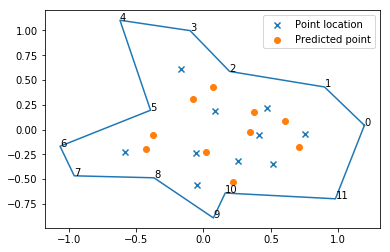

In [58]:

plt.clf()
for i in range(1000):
    random_contour=apply_procrustes(generate_contour(12))
    random_nb_of_points,random_point_coordinated_delaunay=get_extrapoints_target_length(random_contour,0.8,algorithm='del2d')
    if random_nb_of_points==nb_of_points:
            break
random_contour_reshaped=random_contour.reshape(1,2*12)
random_contour_with_target=np.hstack([random_contour_reshaped,[[.8]]])
_,contour_length,contour_angles=extract_lengths_angles(random_contour_with_target,12)
distance_from_barycenter=extract_distances_from_barycenter(random_contour_with_target,12)
random_contour_with_target=np.hstack([random_contour_with_target,contour_angles])
random_contour_with_target=np.hstack([random_contour_with_target,contour_length])
random_contour_with_target=np.hstack([random_contour_with_target,distance_from_barycenter])
#random_contour_with_target=np.hstack([contour_length,contour_angles])

plot_contour(random_contour)
random_point_coordinated_delaunay=np.array(random_point_coordinated_delaunay)
random_point_coordinated_delaunay.reshape(nb_of_points,2)
mid_point_delaunay=(random_point_coordinated_delaunay[0]+random_point_coordinated_delaunay[1])/2
plt.scatter(random_point_coordinated_delaunay[:,0],random_point_coordinated_delaunay[:,1],label='Point location',marker='x')



random_x_variable=Variable(torch.from_numpy(random_contour_with_target))
random_x_variable=random_x_variable.expand(1000,2*12+3*12+1).type(torch.FloatTensor)
my_net=my_net.cpu()
my_net.eval()
random_prediction=my_net(random_x_variable)

random_prediction=random_prediction.data[0].numpy()
predicted_coordinates=acquire_points_from_deformation(random_prediction,nb_of_points)
predicted_coordinates=np.array(predicted_coordinates).reshape(2*nb_of_points,2)
plt.scatter(predicted_coordinates[:,0][::2],predicted_coordinates[:,1][::2],label='Predicted point')

plt.legend()


regression_error(real_points=random_point_coordinated_delaunay,prediction_points=predicted_coordinates[::2],nb_of_interior_points=nb_of_points)


In [ ]:

_,_,contour_angles=extract_lengths_angles(random_contour_with_target,12)


In [ ]:
# Error between predicted points and real point in a multiple point framework

contour_points=sort_points(random_point_coordinated_delaunay.reshape(1,1,3,2),3).reshape(3,2)
#plot_contour(apply_procrustes(contour_points))
predicted_contour_points=sort_points(predicted_coordinates[0::2].reshape(1,1,3,2),3).reshape(3,2)
procrustes_predicted_contour_points=apply_procrustes(predicted_contour_points,contour_points)
plot_contour(apply_procrustes(predicted_contour_points,contour_points))
plot_contour(contour_points)
#plot_contour(predicted_contour_points)

error_in_transformation=np.array([np.linalg.norm(predicted_contour_points[indices]-procrustes_predicted_contour_points[indices]) for indices in range(len(predicted_contour_points))])
contour_points,predicted_contour_points
maximum_index,maximum_distance=np.argmax([np.linalg.norm(contour_points[index]-procrustes_predicted_contour_points[index]) for index in range(len(contour_points))]),np.max([np.linalg.norm(contour_points[index]-procrustes_predicted_contour_points[index]) for index in range(len(contour_points))])
maximum_distance
maximum_distance,maximum_index,error_in_transformation
total_error=maximum_distance+error_in_transformation[maximum_index]
print(total_error,maximum_index)



print(regression_error(random_point_coordinated_delaunay[::2],predicted_coordinates[0::2],3))

In [ ]:
# Taking as input the lengths and angles of the polygon

data,_,_=extract_lengths_angles(polygons_reshaped,12)
#data=extract_lengths_angles_in_triangle_form(polygons_reshaped,12)

x_tensor_conv=torch.from_numpy(data[:nb_of_training_data]).type(torch.FloatTensor)
x_tensor_test_conv=torch.from_numpy(data[nb_of_training_data:]).type(torch.FloatTensor)
x_variable_conv,x_variable_test_conv=Variable(x_tensor_conv),Variable(x_tensor_test_conv)

In [ ]:
# Reshape variables for convolutional neural net

x_variable_conv,x_variable_test_conv=x_variable_conv.resize(x_variable_conv.size()[0],1,x_variable_conv.size()[1]),Variable(x_tensor_test_conv.view(x_variable_test_conv.size()[0],1,x_variable_test_conv.size()[1]),volatile=True)

In [ ]:
torch.cuda.empty_cache()
#my_conv_net=triangle_convoluting_net(nb_of_filters=20,nb_of_hidden_nodes=10,out_dimension=4*12+2)

my_conv_net=alt_conv_net(nb_of_filters=5,nb_of_hidden_nodes=100,out_dimension=4*12+2)
print(my_conv_net)


In [ ]:
optimizer = torch.optim.Adam(my_conv_net.parameters(), lr=1e-4,weight_decay=0.7)

loss_func = torch.nn.MSELoss(size_average=False) 


In [ ]:
if  torch.cuda.is_available():
    loss_func.cuda()
    my_conv_net.cuda()
    x_variable_conv , y_variable,x_variable_test_conv,y_variable_test= x_variable_conv.cuda(), y_variable.cuda(),x_variable_test_conv.cuda(),y_variable_test.cuda()
    print("cuda activated")


In [ ]:
batch_size=int(x_variable_conv.size()[0])
nb_of_epochs=33000
# Train the network #
my_conv_net.train()
for t in range(nb_of_epochs):
    sum_loss=0
    for b in range(0,x_variable_conv.size(0),batch_size):
        out = my_conv_net(x_variable_conv.narrow(0,b,batch_size))                 # input x and predict based on x        
        #loss = loss_func(out, y_variable.narrow(0,b,batch_size))     # must be (1. nn output, 2. target), the target label is NOT one-hotted        
        loss=my_torch_loss_function(out, y_variable.narrow(0,b,batch_size).resize(batch_size,nb_of_points*4+2)).sum().cuda()

        sum_loss+=loss.data[0]
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        #print(t,loss.data[0])
        optimizer.step()        # apply gradients
    if t%10==0:
        my_conv_net.eval()
        out_test_conv=my_conv_net(x_variable_test_conv)
        #test_loss=loss_func(out_test_conv,y_variable_test).data[0]
        test_loss=my_torch_loss_function(out_test_conv, y_variable_test.resize(len(y_variable_test),nb_of_points*4+2)).sum().data[0]

        
        
        my_conv_net.train()
        print("Epoch:",t,"Training Loss:",sum_loss/x_variable_conv.size(0),"Test Loss:",test_loss/x_variable_test_conv.size(0))

13 0.2191585767492475 -0.2900295028119402 0
14 0.003009820581806462 -0.5156914314898119 0
15 -0.1831242652554345 -0.0299518490960665 0
16 0.5138857857122678 -0.480016527331137 0
17 0.3783820877747181 0.1739080499460676 0
18 -0.2995311555002407 -0.2427133569979735 0
19 0.4554059003903581 -0.06765084028766526 0
20 0.8046923311921836 0.2437843896766339 0
21 0.2369716504252916 -0.4998587195304494 0
22 0.06954910224193017 -0.6534395907742776 0
23 -0.1567944759473648 -0.5571159266265009 0
24 0.1014543219595113 0.08225916364797013 0
25 -0.5675720704935882 0.2648920043023894 0
26 -0.08975396118687962 -0.2449928671407565 0
27 -0.1707286935976337 0.3568024339586203 0
28 0.6124297636992232 0.05672752289679316 0
29 -0.2927312442343393 -0.4293505462261763 0
30 0.4215362580511499 -0.2916207791178258 0
31 0.6381042992312168 -0.3099574509362348 0
32 -0.1193828581483766 -0.4111650647828054 0
33 -0.489229178432317 -0.05215786961445613 0
34 -0.7729455125057568 0.03560616279041743 0
35 0.05707757082210788

array([ 0.31710768,  0.02947322,  0.15350033,  0.36708528,  0.22880685,
       -0.10605225,  0.40237805,  0.35835713,  0.07111871, -0.13329557,
        0.54247904,  0.19693363, -0.0883254 , -0.31581506,  0.45388404,
        0.07455856, -0.34137675, -0.1703098 ,  0.3430122 , -0.17395464,
       -0.33550903, -0.2921546 ,  0.04991145, -0.2207306 , -0.38830137,
       -0.11073624, -0.14381233, -0.33140713, -0.3349758 ,  0.16160469,
       -0.3361093 , -0.36372793, -0.06014021,  0.21365911, -0.5013236 ,
       -0.28903657,  0.16250135,  0.2939509 , -0.50826854, -0.07061396,
        0.28746492,  0.41270238, -0.3249956 , -0.02397906,  0.49616912,
        0.12523206, -0.14116508,  0.29953206, -0.02113278,  0.03213254],
      dtype=float32)

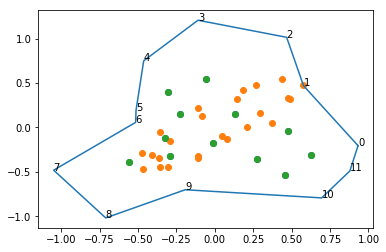

In [57]:
# Testing convolutional network 


plt.clf()
for i in range(1000):
    random_contour_conv=apply_procrustes(generate_contour(12))
    random_nb_of_points,random_point_coordinated_delaunay=get_extrapoints_target_length(random_contour_conv,0.8,algorithm='del2d')
    if random_nb_of_points==nb_of_points:
            break
random_contour_reshaped_conv=random_contour_conv.reshape(1,2*12)
random_contour_with_target_conv=np.hstack([random_contour_reshaped_conv,[[.8]]])

plot_contour(random_contour_conv)
real_points=np.array(random_point_coordinated_delaunay)
plt.scatter(real_points[:,0],real_points[:,1])

data,_,_=extract_lengths_angles(random_contour_with_target_conv.reshape(1,25),12)
#data=extract_lengths_angles_in_triangle_form(random_contour_with_target_conv.reshape(1,25),12)

random_x_variable_conv=Variable(torch.from_numpy(data).type(torch.FloatTensor)).expand(1000,1,25).cuda()

my_conv_net.eval()
predicted_df_and_br=my_conv_net(random_x_variable_conv).cpu()
predicted_df_and_br=predicted_df_and_br[0].data.numpy()

predicted_points=acquire_points_from_deformation(predicted_df_and_br,12)
predicted_points=np.array(predicted_points)

real_points=np.array(random_point_coordinated_delaunay)

plt.scatter(predicted_points[:,0],predicted_points[:,1])
plt.scatter(real_points[:,0],real_points[:,1])

predicted_df_and_br

In [38]:
data.shape

(1, 37)

In [218]:
data

array([[0.52683707, 0.81007919, 0.53668459, 0.41284485, 0.58972531,
        0.64828769, 0.81285994, 1.0013437 , 0.2380856 , 0.61617677,
        0.68318367, 0.61139103, 2.04634931, 2.19383182, 2.95129436,
        1.82416443, 3.54040685, 1.58576578, 4.88186463, 0.71275544,
        2.16451307, 4.47740056, 1.2643371 , 3.77324317, 0.8       ]])

In [2]:
random_element=apply_procrustes(generate_contour(3))

NameError: name 'apply_procrustes' is not defined

In [ ]:
plot_contour(random_element)
barycenter=get_barycenter(random_element)

In [ ]:
random_element

In [3]:
# Trying seperate network for the barycenter 


y_tensor_barycenter=torch.from_numpy(extract_barycenter(point_coordinates.reshape(len(point_coordinates),2*nb_of_points),nb_of_points)).type(torch.FloatTensor)
y_variable_barycenter=Variable(y_tensor_barycenter[:nb_of_training_data])
y_tensor_barycenter_test=y_tensor_barycenter[nb_of_training_data:]
y_variable_barycenter_test=Variable(y_tensor_barycenter[nb_of_training_data:])

NameError: name 'torch' is not defined

In [ ]:
my_net_barycenter=Net(x_variable.size()[1],y_variable_barycenter.size()[2],nb_of_hidden_layers=2, nb_of_hidden_nodes=45,batch_normalization=True)
torch.cuda.empty_cache()
print("Training data length:",x_variable_test.size()[1],y_variable_barycenter.size()[2])


In [ ]:
optimizer = torch.optim.Adam(my_net_barycenter.parameters(), lr=1e-4,weight_decay=0.3)
loss_func =torch.nn.MSELoss(size_average=False) 


In [ ]:

if  torch.cuda.is_available():
    #loss_func.cuda()
        
    x_variable , y_variable_barycenter=x_variable.cuda(), y_variable_barycenter.cuda()
    x_variable_test,y_variable_barycenter_test= Variable(x_tensor_test.cuda(),volatile=True),Variable(y_tensor_barycenter_test.cuda(),volatile=True)

    print("cuda activated")


In [ ]:
batch_size=int(x_variable.size()[0] )
nb_of_epochs=23000
my_net_barycenter.cuda()
#my_net.cpu()

# Train the network #
my_net_barycenter.train()
for t in range(nb_of_epochs):
    sum_loss=0
    for b in range(0,x_variable.size(0),batch_size):
        out = my_net_barycenter(x_variable.narrow(0,b,batch_size))                 # input x and predict based on x
        loss= loss_func(out, y_variable_barycenter.narrow(0,b,batch_size))     # must be (1. nn output, 2. target), the target label is NOT one-hotted
        sum_loss+=loss.data[0]
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients

        optimizer.step()        # apply gradients
    if t%10==0: 
        my_net_barycenter.eval()
        out_test=my_net_barycenter(x_variable_test)   
        
        test_loss=loss_func(out_test, y_variable_barycenter_test)
        print("Epoch:",t,"Training Loss:",sum_loss/(x_variable.size(0)),test_loss.data[0]/(x_variable_test.size(0)))
        my_net.train()


13 -0.05568314219353468 0.002519668884081854 -0
14 -0.4109898595469855 0.2489642068483436 -0
15 -0.4900887901485589 -0.1801269125775185 0
16 0.2702173035276295 0.2081952882348311 0
17 0.2696795222527284 -0.7176838424424394 0
18 0.08808105550607472 0.4720116802330942 0
13 -0.08675257535496986 0.02253086088514891 0
14 -0.2027575095732738 -0.4536663705683257 0
15 0.1772160785910867 0.4995345067693739 0
16 -0.5068347880749873 0.0200993556006923 0
17 0.3231277168443751 -0.2048432602270779 0
18 -0.3012797974193605 -0.1772456902838346 0
19 -0.736160392484604 -0.1079278571107537 0
20 0.1327079256998553 0.8411332017920136 0
21 0.2265992290362324 0.1049034505567851 0
22 -0.2804707773917259 0.2408825971793528 0
23 0.4607855482730201 0.3760019895816634 0
24 -0.5248660521285465 -0.16978112690237 0
25 0.1784932136795091 -0.5129122172218632 0
26 0.3964240279883187 -0.7526013688183613 0
27 0.04309493147068798 -0.229675423076602 0
28 -0.2886980093623265 0.0236427304668028 0
29 -0.0239400619554018 0.268

NameError: name 'my_net_barycenter' is not defined

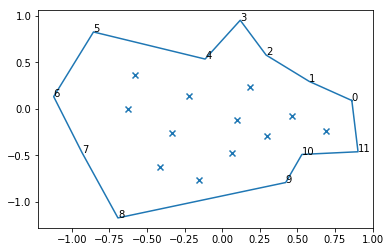

In [427]:

plt.clf()
for i in range(1000):
    random_contour=apply_procrustes(generate_contour(12))
    random_nb_of_points,random_point_coordinated_delaunay=get_extrapoints_target_length(random_contour,0.8,algorithm='del2d')
    if random_nb_of_points==nb_of_points:
            break
random_contour_reshaped=random_contour.reshape(1,2*12)
random_contour_with_target=np.hstack([random_contour_reshaped,[[.8]]])




plot_contour(random_contour)
random_point_coordinated_delaunay=np.array(random_point_coordinated_delaunay)
random_point_coordinated_delaunay.reshape(nb_of_points,2)
mid_point_delaunay=(random_point_coordinated_delaunay[0]+random_point_coordinated_delaunay[1])/2
plt.scatter(random_point_coordinated_delaunay[:,0],random_point_coordinated_delaunay[:,1],label='Point location',marker='x')



random_x_variable=Variable(torch.from_numpy(random_contour_with_target))
random_x_variable=random_x_variable.expand(1000,2*12+1).type(torch.FloatTensor)
my_net=my_net.cpu()
my_net.eval()
my_net_barycenter=my_net_barycenter.cpu()
my_net_barycenter.eval()
random_prediction=my_net(random_x_variable)
random_prediction_barycenter=my_net_barycenter(random_x_variable)


random_prediction=random_prediction.data[0].numpy()
random_prediction_barycenter=random_prediction_barycenter.data[0].numpy()

print(random_prediction)
predicted_coordinates=acquire_points_from_deformation(random_prediction,nb_of_points)
predicted_coordinates=np.array(predicted_coordinates).reshape(2*nb_of_points,2)

random_prediction[-2:]=random_prediction_barycenter
print(random_prediction)

predicted_coordinates2=acquire_points_from_deformation(random_prediction,nb_of_points)
predicted_coordinates2=np.array(predicted_coordinates2).reshape(2*nb_of_points,2)

plt.scatter(predicted_coordinates[:,0],predicted_coordinates[:,1],label='Predicted point location')
plt.scatter(predicted_coordinates2[:,0],predicted_coordinates2[:,1],label='Predicted point location with different NN for barycenter',marker='d')

plt.legend()


In [ ]:
deformation_gradients=deformation_gradients_with_barycenters.reshape(len(deformation_gradients_with_barycenters),4*nb_of_points+2)[:,:4*nb_of_points]

In [ ]:
deformations=[]
for i in range(nb_of_points):
    deformations.append( deformation_gradients.reshape(len(deformation_gradients),nb_of_points,4)[:,i])

In [ ]:
deformations=np.array(deformations)

In [ ]:
deformation_gradients_with_barycenters.shape,deformation_gradients.shape,deformations.shape

In [ ]:
deformations.reshape(nb_of_points*len(polygons_reshaped),4)

In [ ]:
deformation_index=np.empty([len(polygons_reshaped),1])

In [ ]:
polygons_and_deformation_index=np.array(polygons_and_deformation_index)
polygons_and_deformation_index=polygons_and_deformation_index.reshape(nb_of_points*len(polygons_reshaped),2*nb_of_points+2)

In [ ]:
deformations_indexed=deformations[0].reshape(len(polygons_reshaped),1,4)

In [ ]:
# 80/20 training/test data ratio

nb_of_test_data=int(len(polygons_reshaped)*0.2)
nb_of_training_data=int(len(polygons_reshaped)-nb_of_test_data)
nb_of_test_data,nb_of_training_data


In [ ]:
# Taking the coordinates, the target edge lentgh and the deformation index as an input
x_tensor=torch.from_numpy(polygons_reshaped[:nb_of_training_data]).type(torch.FloatTensor)
x_tensor_test=torch.from_numpy(polygons_reshaped[nb_of_training_data:]).type(torch.FloatTensor)
x_variable,x_variable_test=Variable(x_tensor),Variable(x_tensor_test)


In [ ]:
# output is now the deformation gradient of each traingle according to an assigned index



y_multiple_tensor=torch.from_numpy(deformations[0][:nb_of_training_data]).type(torch.FloatTensor)
y_multiple_tensor_test=torch.from_numpy(deformations[0][nb_of_training_data:]).type(torch.FloatTensor)

y_multiple_variable,y_multiple_variable_test=Variable(y_multiple_tensor),Variable(y_multiple_tensor_test)


In [ ]:
my_net_index=Net(x_variable.size()[1],y_multiple_variable.size()[1],nb_of_hidden_layers=3, nb_of_hidden_nodes=10,batch_normalization=True)
torch.cuda.empty_cache()
print("Training data length:",x_variable_test.size()[1],y_variable.size()[2])


In [ ]:
optimizer = torch.optim.Adam(my_net_index.parameters(), lr=1e-4,weight_decay=0.3)
loss_func =torch.nn.MSELoss(size_average=False) 


In [ ]:

if  torch.cuda.is_available():
    loss_func.cuda()
        
    x_variable , y_multiple_variable=x_variable.cuda(), y_multiple_variable.cuda()
    x_variable_test,y_multiple_variable_test= Variable(x_tensor_test.cuda(),volatile=True),Variable(y_multiple_tensor_test.cuda(),volatile=True)

    print("cuda activated")


batch_size=int(x_variable.size()[0] )
nb_of_epochs=23000
my_net_index.cuda()
#my_net.cpu()

# Train the network #
my_net_index.train()
for t in range(nb_of_epochs):
    sum_loss=0
    for b in range(0,x_variable.size(0),batch_size):
        out = my_net_index(x_variable.narrow(0,b,batch_size))                 # input x and predict based on x
        loss= loss_func(out, y_multiple_variable.narrow(0,b,batch_size))     # must be (1. nn output, 2. target), the target label is NOT one-hotted
        sum_loss+=loss.data[0]
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients

        optimizer.step()        # apply gradients
    if t%10==0: 
        my_net_index.eval()
        out_test=my_net_index(x_variable_test)   
        
        test_loss=loss_func(out_test, y_multiple_variable_test)
        print("Epoch:",t,"Training Loss:",sum_loss/(x_variable.size(0)),test_loss.data[0]/(x_variable_test.size(0)))
        my_net.train()

In [ ]:
y_multiple_variable

In [ ]:

# Creating a list of networks to be trained. Each network is trained to regress on the points of each triangle
# that is formed conneting the barycenter of the interior point polygon with its edges.


network_list=[]
for i in range(nb_of_points):  
    
    deformations_indexed=deformations[i].reshape(len(polygons_reshaped),1,4)
    
    
    # output is now the deformation gradient of each traingle according to an assigned index



    y_multiple_tensor=torch.from_numpy(deformations_indexed[:nb_of_training_data]).type(torch.FloatTensor)
    y_multiple_tensor_test=torch.from_numpy(deformations_indexed[nb_of_training_data:]).type(torch.FloatTensor)

    y_multiple_variable,y_multiple_variable_test=Variable(y_multiple_tensor),Variable(y_multiple_tensor_test)

    net=Net(x_variable.size()[1],y_multiple_variable.size()[2],nb_of_hidden_layers=3, nb_of_hidden_nodes=15,batch_normalization=True)

    
    
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4,weight_decay=0.3)
    loss_func =torch.nn.MSELoss(size_average=False) 

    
    torch.cuda.empty_cache()

    if  torch.cuda.is_available():
        loss_func.cuda()
        
        x_variable , y_multiple_variable=x_variable.cuda(), y_multiple_variable.cuda()
        x_variable_test,y_multiple_variable_test= Variable(x_tensor_test.cuda(),volatile=True),Variable(y_multiple_tensor_test.cuda(),volatile=True)

        print("cuda activated")
        
    
    batch_size=int(x_variable.size()[0] )
    nb_of_epochs=4000
    net.cuda()

    # Train the network #
    net.train()
    for t in range(nb_of_epochs):
        sum_loss=0
        for b in range(0,x_variable.size(0),batch_size):
            out = net(x_variable.narrow(0,b,batch_size))                 # input x and predict based on x
            loss= loss_func(out, y_multiple_variable.narrow(0,b,batch_size))     # must be (1. nn output, 2. target), the target label is NOT one-hotted
            sum_loss+=loss.data[0]
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients

            optimizer.step()        # apply gradients
        if t%10==0: 
            net.eval()
            out_test=net(x_variable_test)   
        
            test_loss=loss_func(out_test, y_multiple_variable_test)
            print("Epoch:",t,"Training Loss:",sum_loss/(x_variable.size(0))," Test Loss :",test_loss.data[0]/(x_variable_test.size(0)))
            net.train()
    net.eval()

    network_list.append(net)

    

In [ ]:
deformation_gradients=[]
for i in range(nb_of_points):
    net=network_list[i]
    prediction=net(x_variable_test).cpu().data.numpy()
    deformation_gradients.append(prediction)
    
deformation_gradients=np.array(deformation_gradients) 
deformation_gradients_resized=[]


        
    

In [ ]:
for j in range(x_variable_test.size()[0]):
    polygon_deformations=[]
    for i in range(nb_of_points):
        polygon_deformations.append(deformation_gradients[i][j])
    polygon_deformations=np.array(polygon_deformations).reshape(1,4*nb_of_points)
    deformation_gradients_resized.append(polygon_deformations)

In [ ]:
deformation_gradients_resized=np.array(deformation_gradients_resized)


In [ ]:
# Visualizing results on test data

plt.clf()
sample_index=659
sample_deformation=deformation_gradients_resized[sample_index]
x_variable=x_variable.cpu()
my_net_barycenter=my_net_barycenter.cpu()
random_x_variable=x_variable_test[sample_index]
random_x_variable=random_x_variable.expand(1000,2*12+1).type(torch.FloatTensor)

prediction_barycenter=my_net_barycenter(random_x_variable).data[0].numpy().reshape(1,2)


def_with_bar=np.hstack([sample_deformation,prediction_barycenter])

predicted_points=np.array(acquire_points_from_deformation(def_with_bar,12))
predicted_points=np.array(predicted_points).reshape(2*nb_of_points,2)
real_coordinates=point_coordinates[nb_of_training_data+sample_index].reshape(nb_of_points,2)
sample_contour=np.delete(polygons_reshaped[nb_of_training_data+sample_index],24).reshape(12,2)
plot_contour(sample_contour)
plt.scatter(real_coordinates[:,0],real_coordinates[:,1])
plt.scatter(predicted_points[:,0],predicted_points[:,1])

In [ ]:
# Visualising result on random data


#plt.clf()
#for i in range(1000):
#    random_contour=apply_procrustes(generate_contour(12))
#    random_nb_of_points,random_point_coordinated_delaunay=get_extrapoints_target_length(random_contour,0.8,algorithm='del2d')
#    if random_nb_of_points==nb_of_points:
#            break
random_contour_reshaped=random_contour.reshape(1,2*12)
random_contour_with_target=np.hstack([random_contour_reshaped,[[.8]]])





random_variable=Variable(torch.from_numpy(random_contour_with_target).type(torch.FloatTensor))
random_variable=random_variable.expand_as(x_variable_test)

random_deformation_gradients=[]
for i in range(nb_of_points):
    net=network_list[i]
    net=net.cpu()
    prediction=net(random_variable).cpu().data.numpy()
    random_deformation_gradients.append(prediction)
    
random_deformation_gradients=np.array(random_deformation_gradients) 
random_deformation_gradients_resized=[]

for j in range(random_variable.size()[0]):
    polygon_deformations=[]
    for i in range(nb_of_points):
        polygon_deformations.append(random_deformation_gradients[i][j])
    polygon_deformations=np.array(polygon_deformations).reshape(1,4*nb_of_points)
    random_deformation_gradients_resized.append(polygon_deformations)


random_prediction_barycenter=my_net_barycenter(random_variable).data[0].numpy().reshape(1,2)


random_sample_deformation=random_deformation_gradients_resized[0]




def_with_bar=np.hstack([random_sample_deformation,random_prediction_barycenter])






random_predicted_points=np.array(acquire_points_from_deformation(def_with_bar,12))
random_predicted_points=np.array(random_predicted_points).reshape(2*nb_of_points,2)


plt.scatter(random_predicted_points[:,0],random_predicted_points[:,1],label='Prediction using multiple NNs')

plot_contour(random_contour)
random_point_coordinated_delaunay=np.array(random_point_coordinated_delaunay)
random_point_coordinated_delaunay.reshape(nb_of_points,2,)
#plt.scatter(random_point_coordinated_delaunay[:,0],random_point_coordinated_delaunay[:,1],label='Point location',marker='x')



plt.legend()




In [ ]:
random_deformation_gradients_resized

In [28]:

    #contour_barycenter_distances.append(distances_from_barycenter)
#contour_barycenter_distances=np.array(contour_barycenter_distances)


In [ ]:
plot_contour(polygon)
plt.scatter(polygon_barycenter[0],polygon_barycenter[1])

(44973, 12)

In [22]:
distances_from_barycenter


[0.7439891867039772,
 0.6329082815113287,
 0.72343688300655,
 1.3455405775169296,
 0.9716423448782179,
 0.5362334949191034,
 0.7322431783003066,
 1.1644061228987055,
 1.1825842413776904,
 0.8176587868812325,
 1.0447014757385589,
 1.1656516636572016]

In [332]:
np.linalg.norm(polygon-polygon_barycenter.repeat(12))


ValueError: operands could not be broadcast together with shapes (12,2) (24,) 

In [ ]:
polygon_barycenter.du